## 1. NumpyNN

Let's implement neural network infrastructure with Numpy!

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [7]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        input_grad = module.backward(input, output_grad)
    """
    def __init__ (self):
        self._output = None
        self._input_grad = None
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        self._output = self._compute_output(input)
        return self._output

    def backward(self, input, output_grad):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self._input_grad = self._compute_input_grad(input, output_grad)
        self._update_parameters_grad(input, output_grad)
        return self._input_grad
    

    def _compute_output(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which will be stored in the `_output` field.

        Example: in case of identity operation:
        
        output = input 
        return output
        """
        raise NotImplementedError
        

    def _compute_input_grad(self, input, output_grad):
        """
        Returns the gradient of the module with respect to its own input. 
        The shape of the returned value is always the same as the shape of `input`.
        
        Example: in case of identity operation:
        input_grad = output_grad
        return input_grad
        """
        
        raise NotImplementedError
    
    def _update_parameters_grad(self, input, output_grad):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zero_grad(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def get_parameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def get_parameters_grad(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

### Sequential container

Define a forward and backward pass procedures.

In [8]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `_output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add_module(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def _compute_output(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        # Your code goes here. ################################################
        self.output = []
        next_output = input
        
        for module in self.modules:
            next_output = module.forward(next_output)
            self.output.append(next_output)
        y = self.output[-1]
    
        return y

    def _compute_input_grad(self, input, output_grad):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, output_grad)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            grad_input = module[0].backward(input, g_1)   
             
             
        !!!
                
        To each module you need to provide the input, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass) 
        and NOT `input` to this Sequential module. 
        
        !!!
        
        """

        # Your code goes here. ################################################
        next_grad = output_grad
        for n_module in range(len(self.modules) - 1, 0, -1):
            next_grad = self.modules[n_module].backward(self.output[n_module-1], next_grad)
        grad_input = self.modules[0].backward(input, next_grad)
        
        return grad_input
      

    def zero_grad(self): 
        for module in self.modules:
            module.zero_grad()
    
    def get_parameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.get_parameters() for x in self.modules]
    
    def get_parameters_grad(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.get_parameters_grad() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self, x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

## Layers

### 1. Linear transform layer

Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform

    input: batch_size x n_feats1
    output: batch_size x n_feats2



In [9]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def _compute_output(self, input):
        # Your code goes here. ################################################
        output = input @ self.W.T + self.b
        return output
    
    def _compute_input_grad(self, input, output_grad):
        # Your code goes here. ################################################
        grad_input = output_grad @ self.W
        return grad_input
    
    def _update_parameters_grad(self, input, output_grad):
        # Your code goes here. ################################################
        self.gradW = output_grad.T @ input
        self.gradb = output_grad.sum(axis=0)
        pass
    
    def zero_grad(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def get_parameters(self):
        return [self.W, self.b]
    
    def get_parameters_grad(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1], s[0])
        return q

## Activation functions

Here's the complete example for the **Rectified Linear Unit non-linearity** (aka **ReLU**):


In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def _compute_output(self, input):
        output = np.maximum(input, 0)
        return output
    
    def _compute_input_grad(self, input, output_grad):
        grad_input = np.multiply(output_grad , input > 0)
        return grad_input
    
    def __repr__(self):
        return "ReLU"

**Sigmoid** activation function

In [11]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

class Sigmoid(Module):
    def __init__(self):
         super(Sigmoid, self).__init__()
    
    def _compute_output(self, input):
        output = sigmoid(input)
        return output
    
    def _compute_input_grad(self, input, output_grad):
        grad_input = np.multiply(output_grad , sigmoid(input) * (1. - sigmoid(input)))
        return grad_input
    
    def __repr__(self):
        return "Sigmoid"

## Criterions

Criterions are used to score the models answers

In [12]:
class Criterion(object):
    def __init__ (self):
        self._output = None
        self._input_grad = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `_compute_output`.
        """
        self._output = self._compute_output(input, target)
        return self._output

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `_compute_input_grad`.
        """
        self._input_grad = self._compute_input_grad(input, target)
        return self._input_grad
    
    def _compute_output(self, input, target):
        """
        Function to override.
        """
        raise NotImplementedError

    def _compute_input_grad(self, input, target):
        """
        Returns gradient of input wrt output
        
        Function to override.
        """
        raise NotImplementedError

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.

    input: batch_size x n_feats
    target: batch_size x n_feats
    output: scalar

In [13]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def _compute_output(self, input, target):   
        output = np.sum(np.power(input - target,2)) / input.shape[0]
        return output 
 
    def _compute_input_grad(self, input, target):
        grad  = (input - target) * 2 / input.shape[0]
        return grad

    def __repr__(self):
        return "MSECriterion"

**LogLoss** criterion

In [14]:
class LogLossCriterion(Criterion):
    def __init__(self):
        super(LogLossCriterion, self).__init__()
        
    def _compute_output(self, input, target):
        # Your code here #################################
        output = -np.sum(target*np.log(input) + (1 - target)*np.log(1 - input))  / input.shape[0]
        
        return output 
 
    def _compute_input_grad(self, input, target):
        # your code here ##################################
        grad = - (target / input - (1 - target)/(1 - input))  / input.shape[0]
        
        return grad

    def __repr__(self):
        return "LogLossCriterion"
    
class SigmoidLogLossCriterion(Criterion):
    def __init__(self):
        super(SigmoidLogLossCriterion, self).__init__()
        
    def _compute_output(self, input, target):
        # Your code here #################################
        sx = sigmoid(input)
        output = -np.sum(target*np.log(sx) + (1 - target)*np.log(1 - sx))  / input.shape[0]
        
        return output 
 
    def _compute_input_grad(self, input, target):
        # your code here ##################################
        grad = (sigmoid(input) - target)  / input.shape[0]
        
        return grad

    def __repr__(self):
        return "SoftmaxLogLossCriterion"
    


## Optimizers

In [15]:
class Optimizer(object):
    def __init__(self, network):
        self._network = network  # contains trainable paramenters and their gradients
        self._state = {}  # any information needed to save between optimizer iterations

    def step(self):
        """
        Updates network parameters
        """
        raise NotImplementedError

### SGD optimizer with momentum

On each step it uses the following formulas for network parameters update: $$v_{t+1} = \mu \cdot v_t + g_{t+1}$$ $$p_{t+1} = p_t - \alpha \cdot v_{t+1}$$ Where $p_t$ - network parameters, $v_t$ - velocity, $\mu$ - momentum, $\alpha$ - learning rate, $g_t$ - gradients.

Check torch.optim.SGD documentation


In [16]:
class SGD(Optimizer):
    def __init__(self, network, lr, momentum=0.0):
        super(SGD, self).__init__(network)
        self._learning_rate = lr
        self._momentum = momentum
        
    def step(self):
        variables = self._network.get_parameters()
        gradients = self._network.get_parameters_grad()
        
        # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
        self._state.setdefault('accumulated_grads', {})
    
        var_index = 0 
        for current_layer_vars, current_layer_grads in zip(variables, gradients):
            for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
                old_grad = self._state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
                np.add(self._momentum * old_grad, current_grad, out=old_grad)
                current_var -= self._learning_rate * old_grad
                var_index += 1

## Training routines

In [17]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [18]:
def train_network(net, optimizer, X, Y, batch_size, n_epoch):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zero_grad()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer.step()

            loss_history.append(loss)
            # print(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)

# 2. Toy example

Once you have implemented the modules, you can check that your framework can actually be used for neural network training. 

Let's start with regression

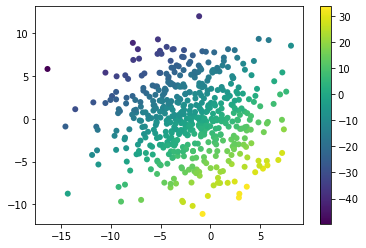

In [19]:
# Generate some data
n_samples = 500

X = np.random.randn(n_samples, 2)*4 + np.array([-2, 0])

Y = 2* X[:,0] - 3 * X[:,1] + 1*np.sin(X[:,0]*X[:,1]) + np.random.randn()
Y = Y[:,None]

sc = plt.scatter(X[:, 0],X[:, 1], c=Y, edgecolors='none')
plt.colorbar(sc)

In [20]:
net = Sequential()
net.add_module(Linear(2, 20))
net.add_module(ReLU())
net.add_module(Linear(20, 1))

criterion = MSECriterion()

print(net)

Linear 2 -> 20
ReLU
Linear 20 -> 1



In [21]:
opt = SGD(net, lr=1e-4, momentum=0.9)

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

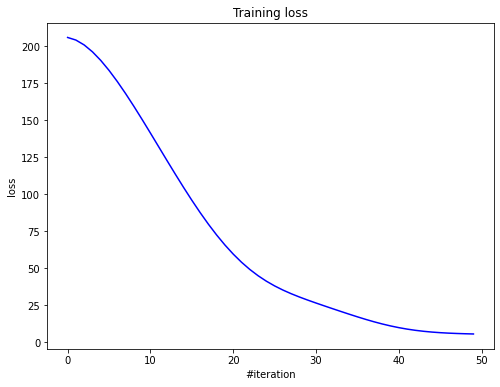

Current loss: 5.425161


In [22]:
train_network(net, opt, X, Y, batch_size=1000, n_epoch=50)

### Proceed with classification

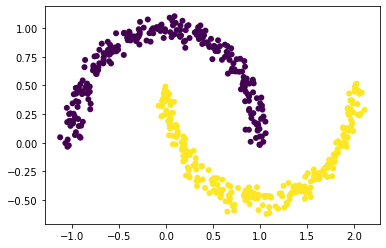

In [23]:
# Generate some data
from sklearn.datasets import make_moons

n_samples = 500

#X_pos = np.random.randn(n_samples, 2) + np.array([1, 1])
#X_neg = np.random.randn(n_samples, 2) + np.array([-1, -1])
#X = np.vstack([X_pos, X_neg])
#Y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])[:, np.newaxis]


X, Y = make_moons(n_samples=n_samples, noise=.05)
Y = Y[:, np.newaxis]

plt.scatter(X[:, 0],X[:, 1], c=Y, edgecolors='none')

Define a classifier

In [57]:
net = Sequential()
net.add_module(Linear(2, 50))
net.add_module(Sigmoid())
net.add_module(Linear(50, 1))

net.add_module(Sigmoid())

criterion = LogLossCriterion()
# criterion = SigmoidLogLossCriterion()

print(net)

Linear 2 -> 50
Sigmoid
Linear 50 -> 1
Sigmoid



Optimizer

In [58]:
opt = SGD(net, lr=1e-1, momentum=0.9)

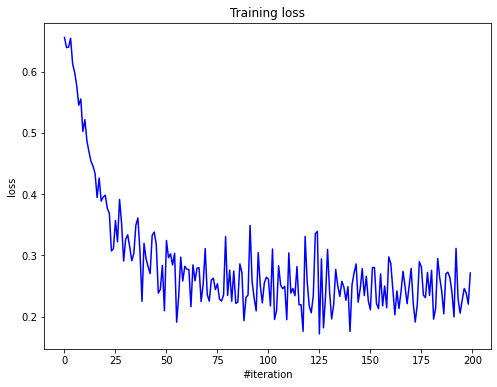

Current loss: 0.270963


In [52]:
train_network(net, opt, X, Y, batch_size=128, n_epoch=50)

Let's see what's the accuracy:

In [53]:
predictions = net.forward(X)
np.sum(1*(predictions > 0.5) == Y)/Y.shape[0]

0.888

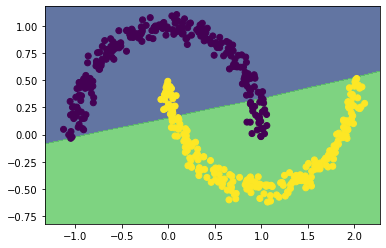

In [54]:
h = 0.2
x_min, x_max = X[:,0].min() - 0.2, X[:,0].max() + 0.2
y_min, y_max = X[:,1].min() - 0.2, X[:,1].max() + 0.2
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = net.forward(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, levels=1)
plt.scatter(X[:,0], X[:,1], c=Y)

In [55]:
def train_network_fancy(net, optimizer, X, Y, batch_size, n_epoch):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zero_grad()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer.step()

            loss_history.append(loss)
            # print(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1,2,1)

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        
        plt.subplot(1,2,2)
        
        h = 0.2
        x_min, x_max = X[:,0].min() - 0.2, X[:,0].max() + 0.2
        y_min, y_max = X[:,1].min() - 0.2, X[:,1].max() + 0.2
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, h),
            np.arange(y_min, y_max, h)
        )
        Z = net.forward(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, levels=1)
        plt.scatter(X[:,0], X[:,1], c=Y)
        
        plt.show()

        print('Current loss: %f' % loss)

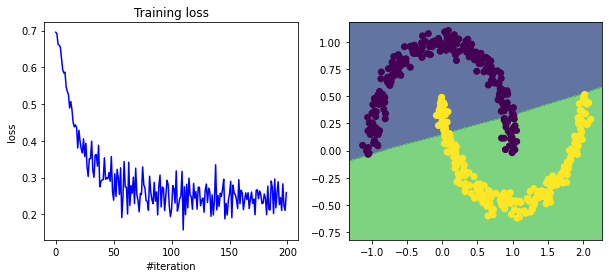

Current loss: 0.259299


In [59]:
train_network_fancy(net, opt, X, Y, batch_size=128, n_epoch=50)

---

### Из д/з: задача 7, Нейронные сети

Дана выборка из двух концентрических окружностей.

Допустим, что для классификации нужно обучить нейронную сеть — причем доступны только следующие слои: линейный $L(n, m)$ ($Wx+b,~x\in\mathbb{R}^{n},~b\in\mathbb{R}^{m}$)  и активация $A$  (сигмоида или $\tanh$), которые разрешено последовательно ставить друг после друга.

Вопрос: какие из приведенных ниже архитектур будут способны разделить выборку со 100\% accuracy? Почему?

1. L(2, 2) -> A -> L(2, 1)
2. L(2, 2) -> A -> L(2, 2) -> A -> L(2, 1)
3. L(2, 3) -> L(3, 1)
4. L(2, 3) -> A -> L(3, 1)
5. L(2, 3) -> L(3, 3) -> L(3, 1)

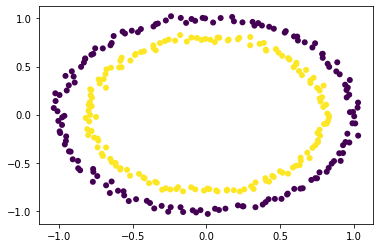

In [92]:
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=300, noise=.02)
Y = Y[:, np.newaxis]

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='none')

In [101]:
# from mlxtend.plotting import plot_decision_regions

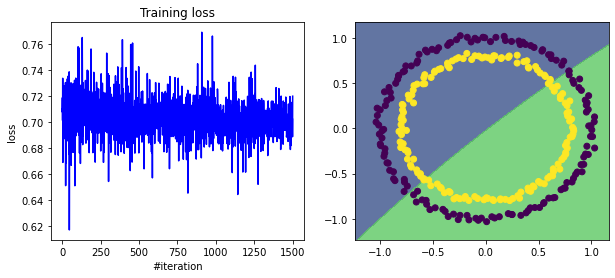

Current loss: 0.720109


In [142]:
net = Sequential()
net.add_module(Linear(2, 3))
# net.add_module(Sigmoid())
# net.add_module(Linear(3, 3))
# net.add_module(Linear(2, 2))
net.add_module(Sigmoid())
net.add_module(Linear(3, 1))

net.add_module(Sigmoid())

# criterion = LogLossCriterion()
criterion = SigmoidLogLossCriterion()

print(net)

opt = SGD(net, lr=1e-2, momentum=0.5)
train_network_fancy(net, opt, X, Y, batch_size=128, n_epoch=500)

---

## 3. Let's MNIST

Loading MNIST

In [ ]:
# import mnist.mnist as mnist_module
# from mnist.mnist import mnist, fashion_mnist

# data = mnist()
# X_train, y_train, X_test, y_test = data

In [60]:
from keras.datasets import mnist

data = mnist.load_data(path="mnist.npz")
(X_train, y_train), (X_test, y_test) = data

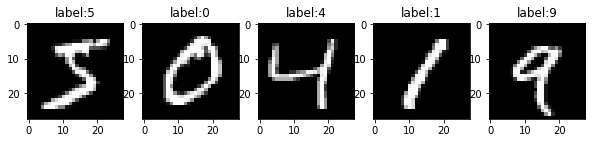

In [61]:
n_samples = 5
plt.figure(figsize=(10,4))
for i in range(n_samples):
    plt.subplot(1,n_samples,i+1)
    plt.imshow(X_train[i], 'gray')
    plt.title('label:{}'.format(y_train[i]))

In [62]:
X_train = X_train[(y_train == 4) | (y_train == 9),:]
y_train = y_train[(y_train == 4) | (y_train == 9)]
y_train = 1*(y_train == 9)

X_test = X_test[(y_test == 4) | (y_test == 9),:]
y_test = y_test[(y_test == 4) | (y_test == 9)]
y_test = 1*(y_test == 9)

In [63]:
X_train.shape, X_test.shape

((11791, 28, 28), (1991, 28, 28))

In [64]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
y_train = y_train[:,None]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
y_test = y_test[:,None]

In [65]:
np.sum(y_train == 1)

5949

In [66]:
y_train.shape

(11791, 1)

In [71]:
net = Sequential()
net.add_module(Linear(X_train.shape[1], 100))
net.add_module(ReLU())
net.add_module(Linear(100, 100))
net.add_module(ReLU())
net.add_module(Linear(100, 1))
# net.add_module(Sigmoid())

criterion = SigmoidLogLossCriterion()
# criterion = LogLossCriterion()

print(net)

Linear 784 -> 100
ReLU
Linear 100 -> 100
ReLU
Linear 100 -> 1



In [72]:
opt = SGD(net, lr=1e-3, momentum=0.9)

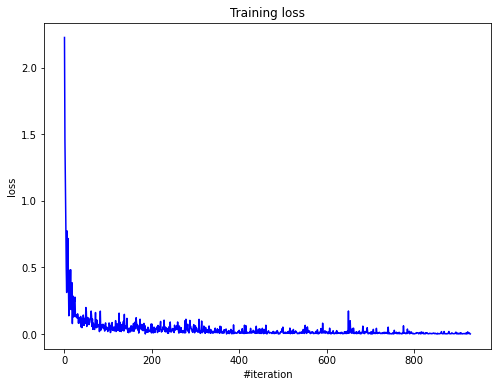

Current loss: 0.000547


In [73]:
train_network(net, opt, X_train, y_train, batch_size=128, n_epoch=10)

In [74]:
predictions = net.forward(X_test)
np.sum(1*(predictions > 0) == y_test)/y_test.shape[0]

0.9884480160723255

In [75]:
predictions = net.forward(X_train)
np.sum(1*(predictions > 0) == y_train)/y_train.shape[0]

0.9999151895513527

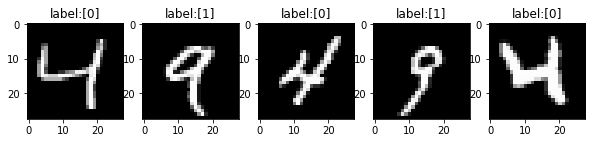

In [76]:
n_samples = 5
plt.figure(figsize=(10,4))
for i in range(n_samples):
    plt.subplot(1,n_samples,i+1)
    plt.imshow(X_train[i].reshape((28,28)), 'gray')
    plt.title('label:{}'.format(y_train[i]))